# Neural Network Mortgage Prepayment Model

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

### Load data from csv files in the ./data directory

In [20]:
if True:
    # load data from csv files
    df = pd.DataFrame()
    for root, dirs, files in os.walk("./data"):
        for name in files:
            file_name = os.path.join(root, name)
            if 'pools_ge250_loans' in file_name:
                if len(df) > 0:
                    df = pd.concat([df,pd.read_csv(file_name)])
                else:
                    df = pd.read_csv(file_name)        

    model_name = 'nn-ppm-from-csv.h5' # for saving a model later

else:
    dill.load_session('notebook_env_all_3_dfs.db')

    print('Loaded data as is:')
    print('attr_df.shape   = ', attr_df.shape)
    print('geo_df.shape    = ', geo_df.shape)
    print('seller_df.shape = ', seller_df.shape)

    nloans = 250
    attr_df = attr_df[attr_df['cnloans']>=nloans]

    print('Data size after filtering for >= 250 loans:')
    print(f'attr_df.shape = {attr_df.shape}')

    geo_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(attr_df,geo_df,on=['cusip','asofdate'],how='left')

    seller_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(df,seller_df,on=['cusip','asofdate'],how='left')

    df.fillna(0,inplace=True)

    model_name = 'nn-ppm-dill-data.h5' # for saving a model later

df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

print('df.shape = ', df.shape)

df.shape =  (594533, 111)


#### Make sure all the fields (except cusip and poolsno) are numerical and there are no NAs

In [21]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594533 entries, 0 to 29999
Data columns (total 111 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   poolno              594533 non-null  object 
 1   asofdate            594533 non-null  int64  
 2   cusip               594533 non-null  object 
 3   spread              594533 non-null  float64
 4   SMM                 594533 non-null  float64
 5   DayCount            594533 non-null  float64
 6   OBal                594533 non-null  float64
 7   CBal                594533 non-null  float64
 8   factor              594533 non-null  float64
 9   Coupon              594533 non-null  float64
 10  Wac                 594533 non-null  float64
 11  Wam                 594533 non-null  float64
 12  Age                 594533 non-null  float64
 13  aols                594533 non-null  float64
 14  waols               594533 non-null  float64
 15  ONLoans             594533 non-nul

In [22]:
df.head()

poolno  asofdate      cusip  spread     SMM  DayCount         OBal  \
0  AJ4035    201405  3138AVPV1   -17.2  1.5337      21.0  564570411.0   
1  AJ4035    201406  3138AVPV1    -9.7  1.2029      21.0  564570411.0   
2  AJ4035    201407  3138AVPV1    -0.9  1.3777      22.0  564570411.0   
3  AJ4035    201408  3138AVPV1     2.3  0.7740      21.0  564570411.0   
4  AJ4035    201409  3138AVPV1     4.5  0.9515      21.0  564570411.0   

           CBal     factor  Coupon  ...  SellerPct_NATIONST  SellerPct_NRESM  \
0  2.922287e+08  51.761249     3.5  ...                 0.0              0.0   
1  2.882252e+08  51.052132     3.5  ...                 0.0              0.0   
2  2.837712e+08  50.263205     3.5  ...                 0.0              0.0   
3  2.810938e+08  49.788969     3.5  ...                 0.0              0.0   
4  2.779412e+08  49.230558     3.5  ...                 0.0              0.0   

   SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  SellerPct_REG  \
0               0.0               0.0              0.0            0.0   
1               0.0               0.0              0.0            0.0   
2               0.0               0.0              0.0            0.0   
3               0.0               0.0              0.0            0.0   
4               0.0               0.0              0.0            0.0   

   SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  Seasonality  
0             0.0               0.0           100.0            5  
1             0.0               0.0           100.0            6  
2             0.0               0.0           100.0            7  
3             0.0               0.0           100.0            8  
4             0.0               0.0           100.0            9  

[5 rows x 111 columns]

### Exploratory data analysis

Here we show some of the typical dependencies between prepayment speeds and some of the pools attributes.

* Prepayment speeds tend to be faster for loans of higher sizes.
* Prepayment speeds tend to be slower for investor loans, because investor loans have much higher closing costs and thus, more expensive to refinance. 
* It does matter which financial institution has originated a loan. The example we give here is comparing loans originated by Quicken to the rest of the loan population. Quicken loans tend to be much faster and it's imoprtant for a model to capture that. 

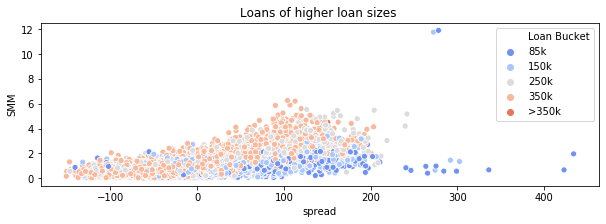

In [23]:
temp = df[(df['Age']>=24) & (df['cnloans']>500)].sample(10000)

temp['Loan Bucket'] = temp['waols'].apply(lambda x: '85k' if x<=85e3 
                                                          else '150k' if x<=150e3 
                                                          else '250k' if x<=250e3 
                                                          else '350k' if x<=350e3
                                                          else '>350k')

plt.figure(figsize=(10,3))
plt.title('Loans of higher loan sizes ')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='Loan Bucket',
                hue_order=['85k','150k','250k','350k','>350k'],
                palette='coolwarm')

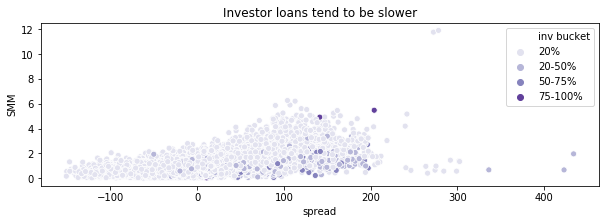

In [24]:
temp['inv bucket'] = temp['OccPct_investor'].apply(lambda x: '20%' if x<20
                                                  else '20-50%' if x<50
                                                  else '50-75%' if x<75
                                                  else '75-100%')
plt.figure(figsize=(10,3))
plt.title('Investor loans tend to be slower')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='inv bucket',palette='Purples',hue_order=['20%','20-50%','50-75%','75-100%'])

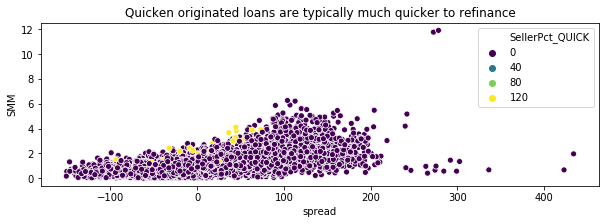

In [25]:
plt.figure(figsize=(10,3))
plt.title('Quicken originated loans are typically much quicker to refinance')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='SellerPct_QUICK',palette='viridis')

### Model features selection and defining train/test split

* In this section we select which features (columns) are to be used in the model and define a test-train split. 
* For the train set we use the mortgage prepayment data observed in the period of 2010-2016. 
* For the test set we use the period from 2017 - Feb 2020. 

In [26]:
model_columns = ['asofdate',
                 'SMM',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                 'Seasonality',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM']

dfm = df[model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.head()

dfm.shape = (594533, 103)


asofdate     SMM  spread  DayCount     factor    Wac    Wam   Age  \
0    201405  1.5337   -17.2      21.0  51.761249  4.169  322.0  32.0   
1    201406  1.2029    -9.7      21.0  51.052132  4.168  321.0  33.0   
2    201407  1.3777    -0.9      22.0  50.263205  4.168  320.0  34.0   
3    201408  0.7740     2.3      21.0  49.788969  4.169  319.0  35.0   
4    201409  0.9515     4.5      21.0  49.230558  4.168  318.0  36.0   

       aols     waols  ...  SellerPct_NCM  SellerPct_NATIONST  \
0  305574.0  305574.0  ...            0.0                 0.0   
1  304845.0  304845.0  ...            0.0                 0.0   
2  304524.0  304524.0  ...            0.0                 0.0   
3  304414.0  304414.0  ...            0.0                 0.0   
4  304682.0  304682.0  ...            0.0                 0.0   

   SellerPct_NRESM  SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  \
0              0.0               0.0               0.0              0.0   
1              0.0               0.0               0.0              0.0   
2              0.0               0.0               0.0              0.0   
3              0.0               0.0               0.0              0.0   
4              0.0               0.0               0.0              0.0   

   SellerPct_REG  SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  
0            0.0             0.0               0.0           100.0  
1            0.0             0.0               0.0           100.0  
2            0.0             0.0               0.0           100.0  
3            0.0             0.0               0.0           100.0  
4            0.0             0.0               0.0           100.0  

[5 rows x 103 columns]

In [27]:
dummies = pd.get_dummies(dfm['Seasonality'],drop_first=True)
dfm = dfm.drop('Seasonality',axis=1)
dfm = pd.concat([dfm,dummies],axis=1)

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (594533, 113)


In [28]:
# define train/test split
# from sklearn.model_selection import train_test_split

# X = dfm.drop(['SMM','asofdate'],axis=1)
# y = dfm['SMM'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

dfm_train = dfm[dfm['asofdate'] <  201701]
dfm_test  = dfm[dfm['asofdate'] >= 201701]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (328786, 111)
y_train.shape = (328786,)


X_test.shape  = (265747, 111)
y_test.shape  = (265747,)


### Building a benchmark model 1 -- Linear regression

* Here we build a simple linear regression model and examine its predictive ability on our prepayment dataset.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [30]:
linear_model = LinearRegression()

In [31]:
linear_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = linear_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
else:
    df['model SMM'] = linear_model.predict(dfm.drop('SMM',axis=1))

In [33]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

In [34]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)

    fig = plt.figure(figsize=fsize)
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

#### The graphs below show that a simple linear model performes quite poorly and one needs a non-linear model for modeling of residential mortagage prepayments. 

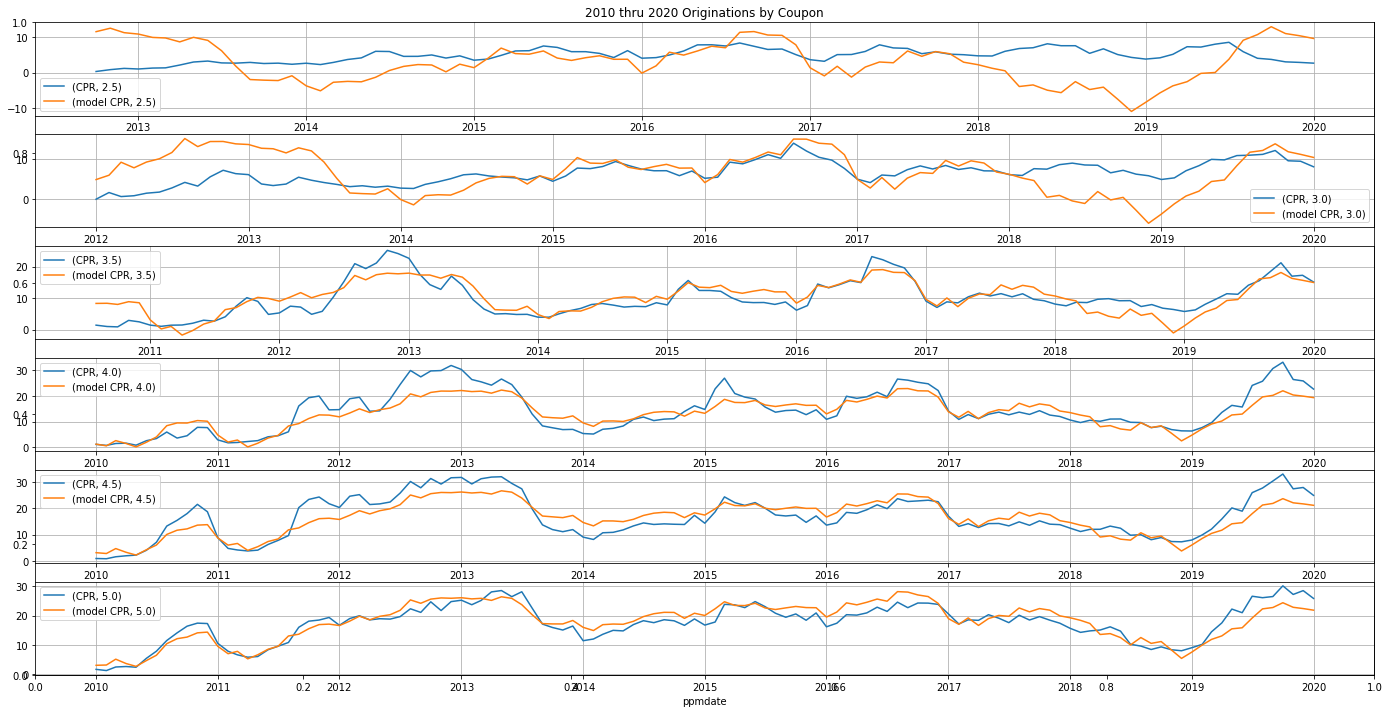

In [35]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

### Building a benchmark model 2 -- Random forest

* We thought it would be interesting to compare our neural network to a random forest as well.
* People in finance prefer decision trees type models to neural networks, when possible, because of the black box nature of neural networks. 

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
rf_model = RandomForestRegressor(n_estimators=30,verbose=1)

In [38]:
rf_model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.9min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [39]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = rf_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
else:
    df['model SMM'] = rf_model.predict(dfm.drop('SMM',axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    7.2s finished


In [40]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

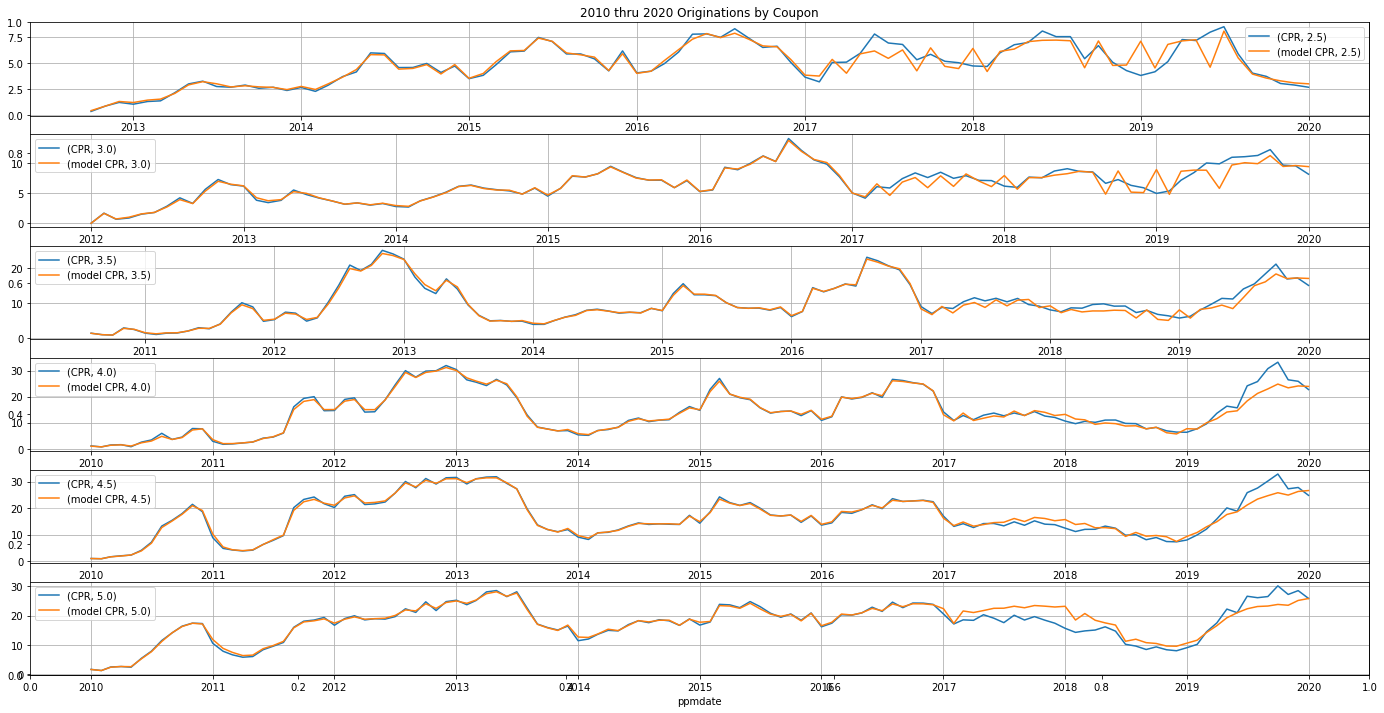

In [41]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

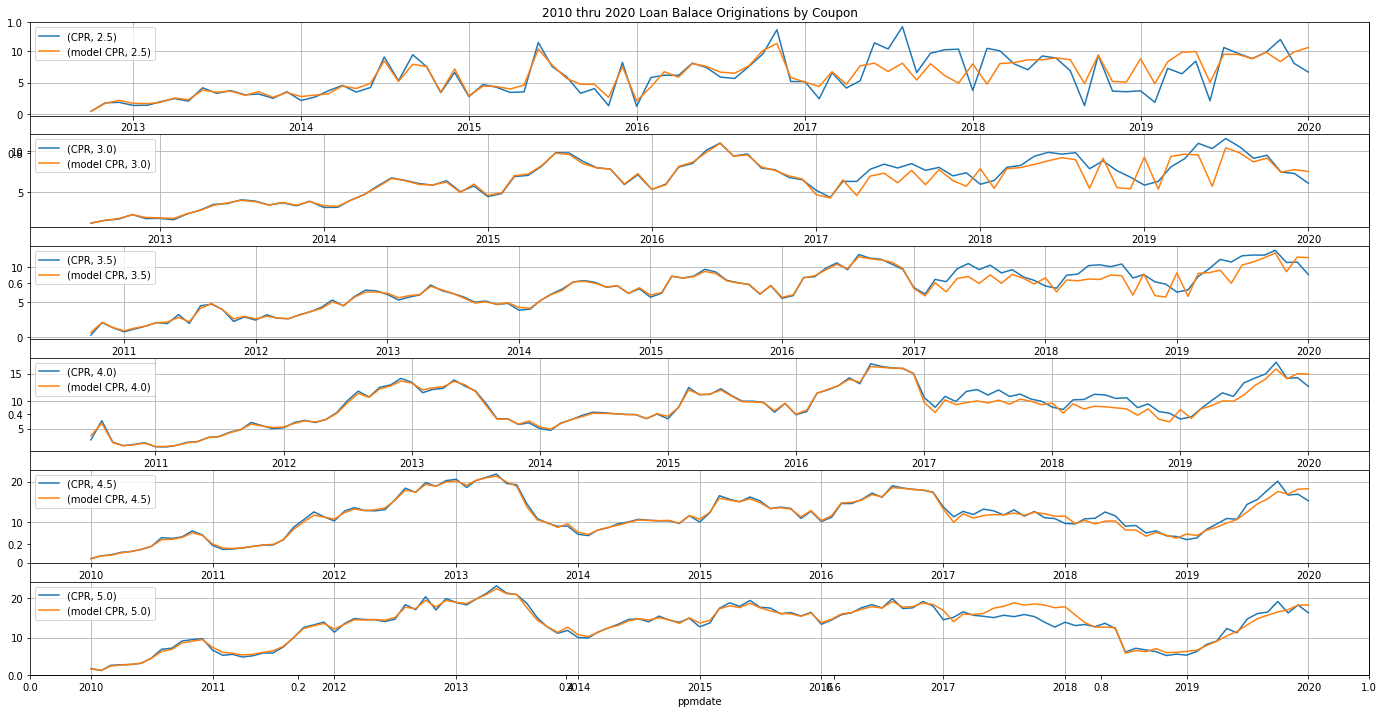

In [42]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

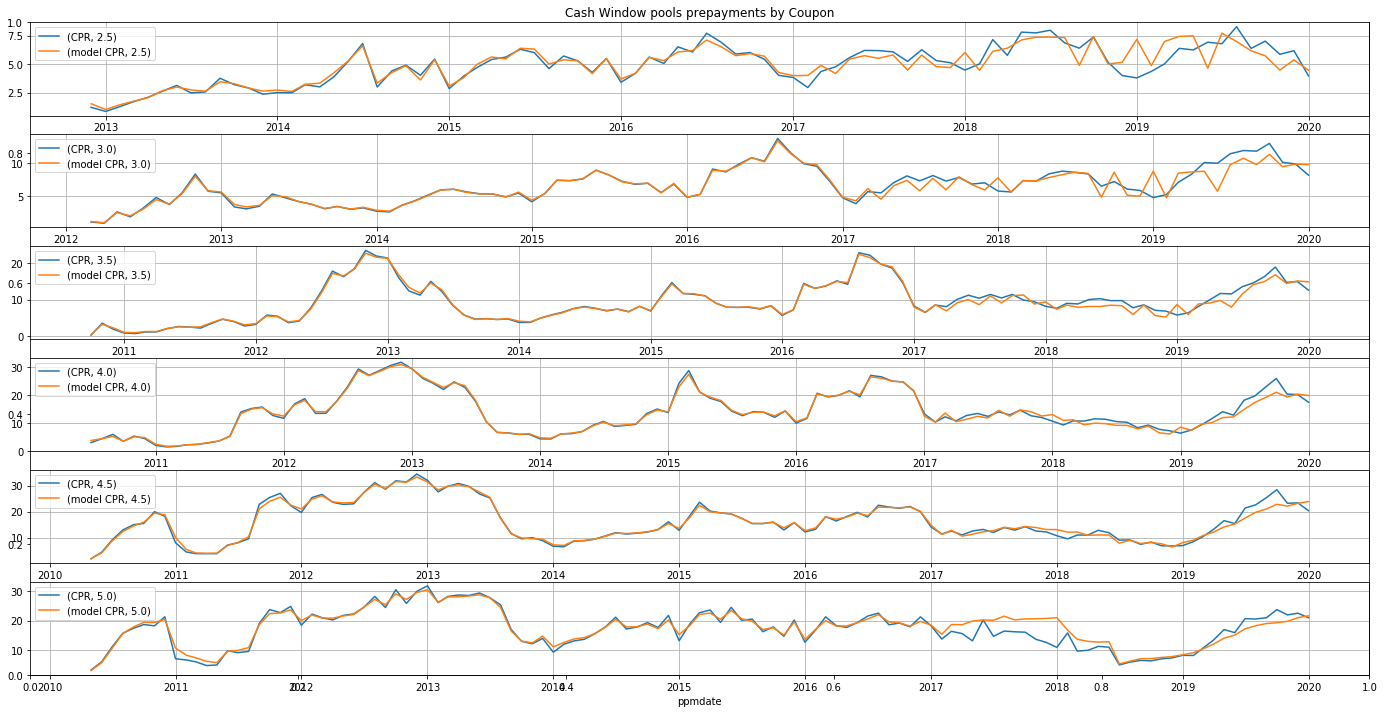

In [43]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

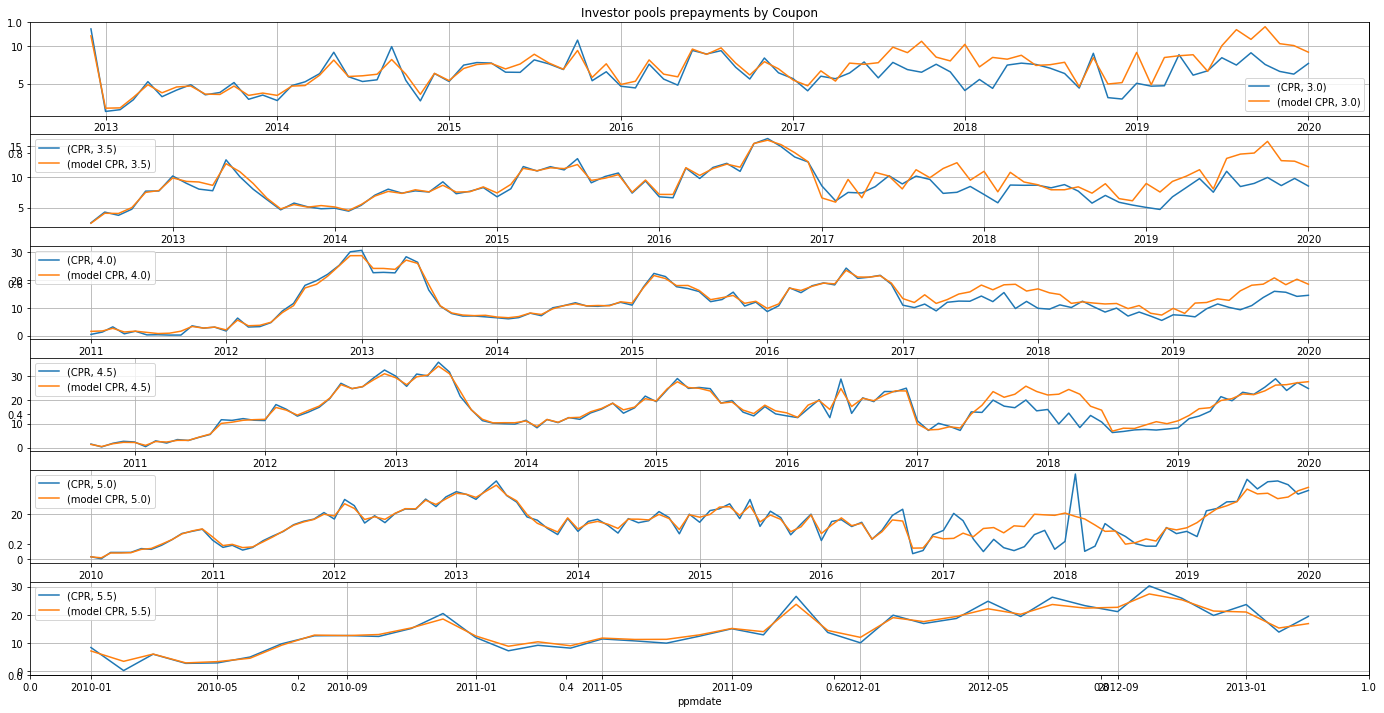

In [44]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

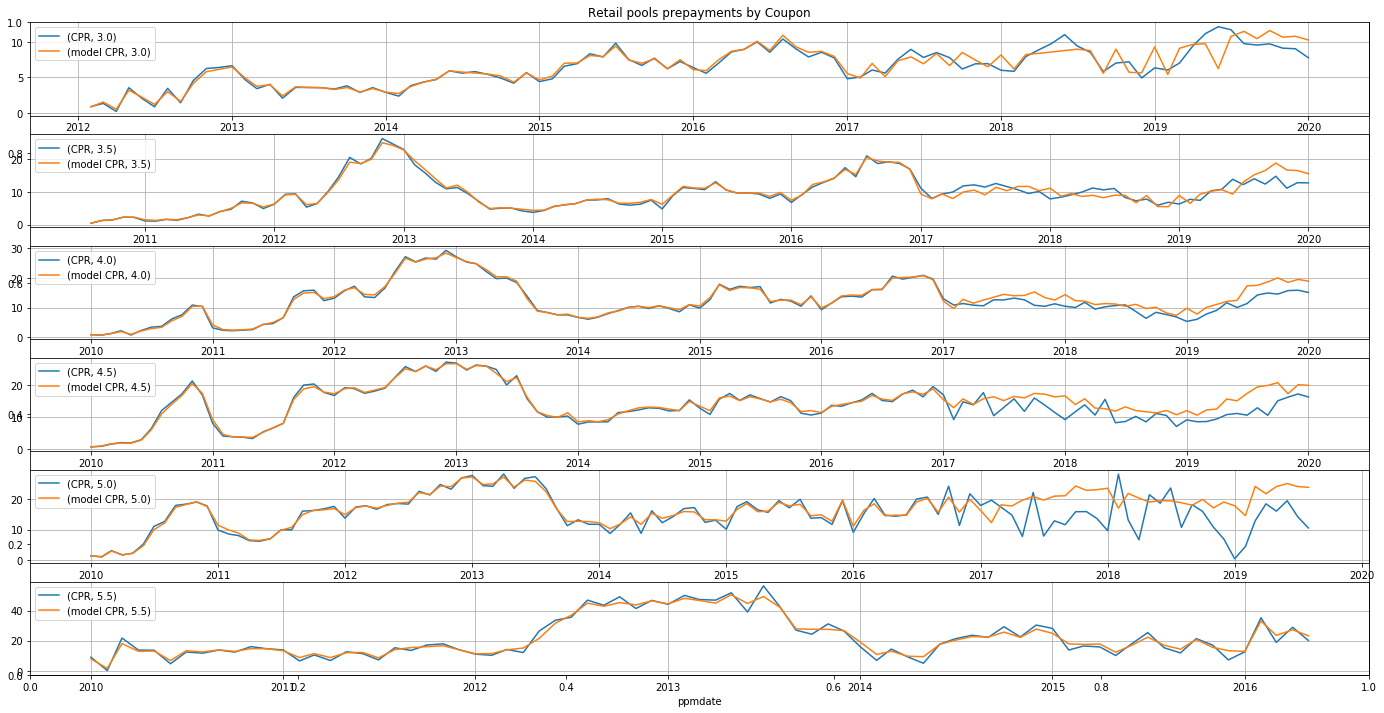

In [45]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

The graphs above appear to show that a random forest model can provide quite unstable model predictions as seen on test set predictions. It appears to be an unsatisfactory model for modeling of residential mortgage prepayments. 

### Building a training of a FF neural-network mortgage prepayment model

In [46]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

In [48]:
model = Sequential()

#input layer / first hidden layer
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dropout(0.5))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x
#model.add(Dense(1)) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

In [49]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=300)

Train on 328786 samples, validate on 265747 samples
Epoch 1/300
328786/328786 [==============================] - 16s 50us/sample - loss: 0.7403 - val_loss: 0.3083
Epoch 2/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.4937 - val_loss: 0.3214
Epoch 3/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.4492 - val_loss: 0.3090
Epoch 4/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.4281 - val_loss: 0.3020
Epoch 5/300
328786/328786 [==============================] - 16s 47us/sample - loss: 0.4169 - val_loss: 0.2982
Epoch 6/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.4033 - val_loss: 0.2943
Epoch 7/300
328786/328786 [==============================] - 16s 50us/sample - loss: 0.3966 - val_loss: 0.2986
Epoch 8/300
328786/328786 [==============================] - 15s 47us/sample - loss: 0.3913 - val_loss: 0.2957
Epoch 9/300
328786/328786 [==============================] -

328786/328786 [==============================] - 58s 176us/sample - loss: 0.3266 - val_loss: 0.2902
Epoch 74/300
328786/328786 [==============================] - 57s 175us/sample - loss: 0.3242 - val_loss: 0.3024
Epoch 75/300
328786/328786 [==============================] - 57s 172us/sample - loss: 0.3250 - val_loss: 0.2932
Epoch 76/300
328786/328786 [==============================] - 57s 173us/sample - loss: 0.3261 - val_loss: 0.2912
Epoch 77/300
328786/328786 [==============================] - 57s 173us/sample - loss: 0.3226 - val_loss: 0.2970
Epoch 78/300
328786/328786 [==============================] - 67s 205us/sample - loss: 0.3238 - val_loss: 0.2909
Epoch 79/300
328786/328786 [==============================] - 57s 173us/sample - loss: 0.3225 - val_loss: 0.2941
Epoch 80/300
328786/328786 [==============================] - 57s 173us/sample - loss: 0.3258 - val_loss: 0.2986
Epoch 81/300
328786/328786 [==============================] - 58s 177us/sample - loss: 0.3225 - val_loss: 0.2

328786/328786 [==============================] - 15s 46us/sample - loss: 0.3093 - val_loss: 0.3086
Epoch 146/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3112 - val_loss: 0.2934
Epoch 147/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3094 - val_loss: 0.3006
Epoch 148/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3082 - val_loss: 0.3038
Epoch 149/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3066 - val_loss: 0.2996
Epoch 150/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3095 - val_loss: 0.2982
Epoch 151/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3088 - val_loss: 0.3076
Epoch 152/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3101 - val_loss: 0.2984
Epoch 153/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3095 - val_loss: 0.30

328786/328786 [==============================] - 16s 48us/sample - loss: 0.3032 - val_loss: 0.3045
Epoch 218/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.3016 - val_loss: 0.2964
Epoch 219/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.3033 - val_loss: 0.3019
Epoch 220/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.3018 - val_loss: 0.3022
Epoch 221/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3018 - val_loss: 0.2912
Epoch 222/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3029 - val_loss: 0.2956
Epoch 223/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3030 - val_loss: 0.2982
Epoch 224/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.3030 - val_loss: 0.2920
Epoch 225/300
328786/328786 [==============================] - 15s 46us/sample - loss: 0.3013 - val_loss: 0.29

328786/328786 [==============================] - 15s 44us/sample - loss: 0.2971 - val_loss: 0.2915
Epoch 290/300
328786/328786 [==============================] - 15s 44us/sample - loss: 0.2974 - val_loss: 0.2979
Epoch 291/300
328786/328786 [==============================] - 16s 47us/sample - loss: 0.2966 - val_loss: 0.2975
Epoch 292/300
328786/328786 [==============================] - 16s 47us/sample - loss: 0.2957 - val_loss: 0.2961
Epoch 293/300
328786/328786 [==============================] - 15s 45us/sample - loss: 0.2968 - val_loss: 0.2946
Epoch 294/300
328786/328786 [==============================] - 15s 44us/sample - loss: 0.2967 - val_loss: 0.3026
Epoch 295/300
328786/328786 [==============================] - 14s 43us/sample - loss: 0.2972 - val_loss: 0.2993
Epoch 296/300
328786/328786 [==============================] - 14s 43us/sample - loss: 0.2967 - val_loss: 0.3034
Epoch 297/300
328786/328786 [==============================] - 14s 44us/sample - loss: 0.2971 - val_loss: 0.29

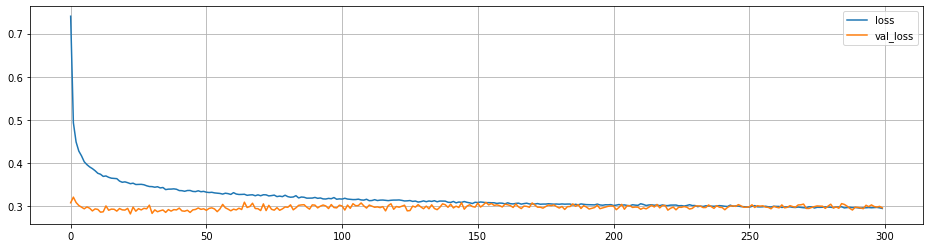

In [50]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

## Model Evaluation and Validation

* In this section we find that the model performs quite well on large populations of loans, however, on individual pools it can be off by quite a bit, especially, if a pool is small. It is normal for prepayment models to behave that way. Afterall, we are modeling the behaviour of people and people are not entirely defined by their FICO score and other similar attributes. 
* We find that the model performs particularly well on  
    * Loan balance pools, i.e. pools where loan size does not exceed 200k.
    * Cash window pools, i.e. pools originated by very small originators.
    * Retail originated loans, i.e. not Broker or Correspondent originated pools.

In [51]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.3983
(test set) mean sq root sq error     = 0.5445
(test set) explained variance score  = 0.3938


(train set) mean absolute error      = 0.375
(train set) mean sq root sq error    = 0.5142
(train set) explained variance score = 0.7539


#### The next two scatter plots show the model performance on a pool by pool basis

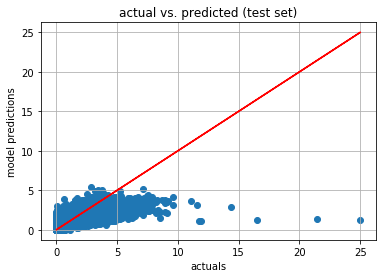

In [52]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

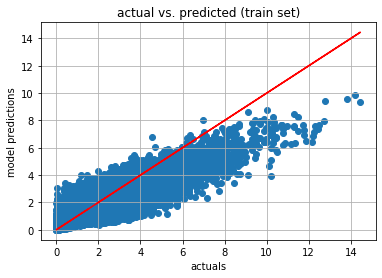

In [53]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

In [54]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
else:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop('SMM',axis=1)))

In [55]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

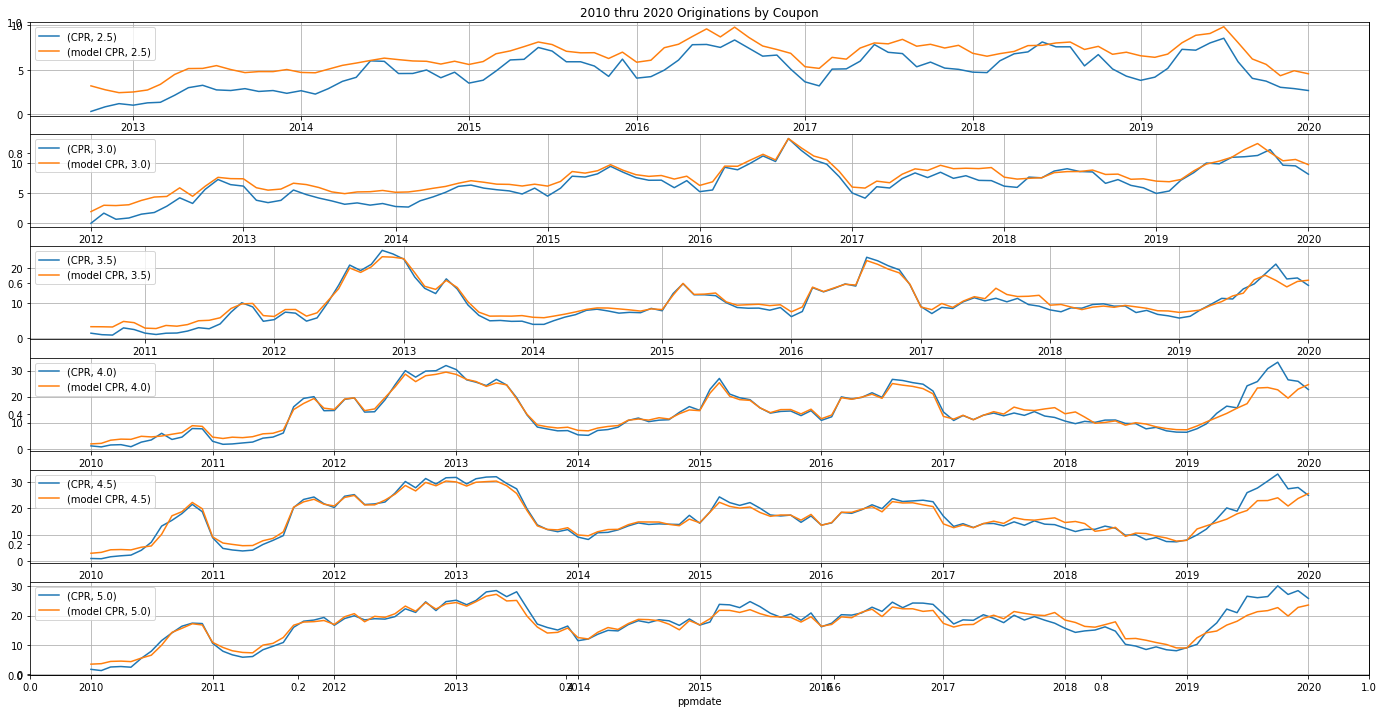

In [56]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

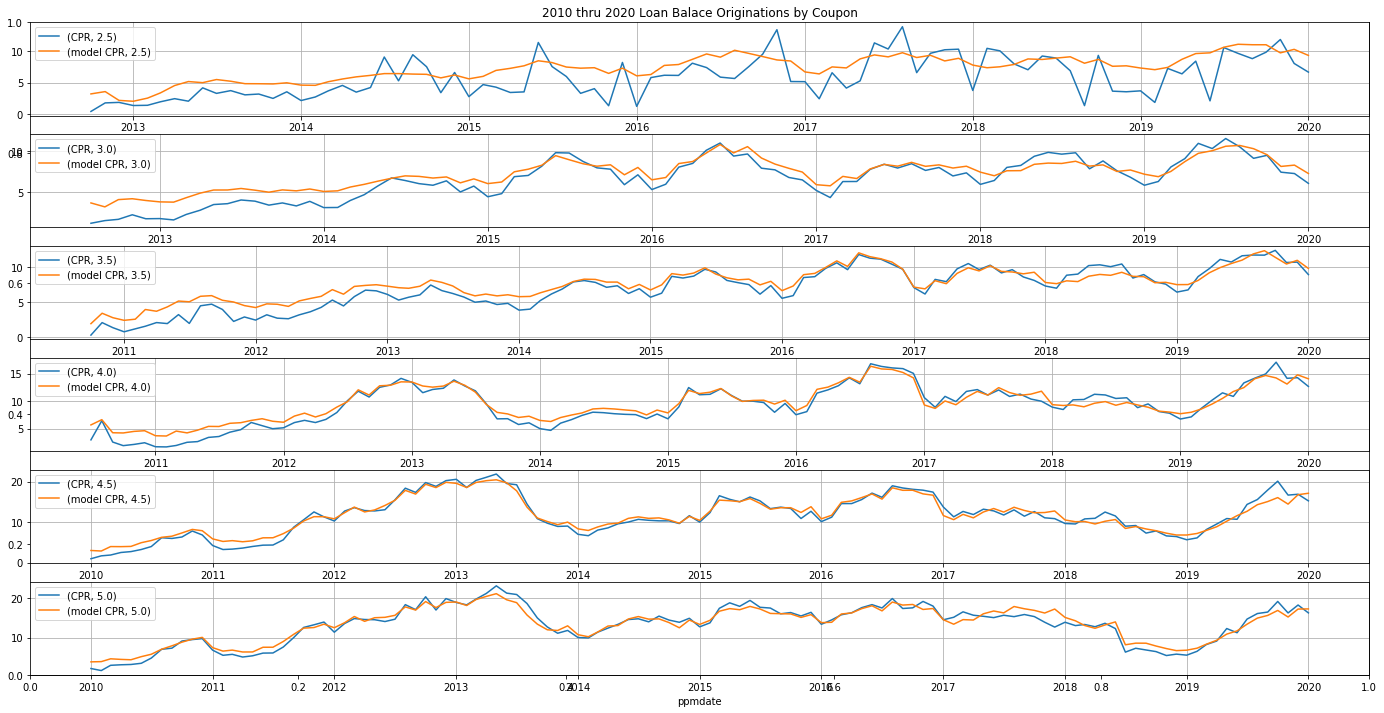

In [57]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

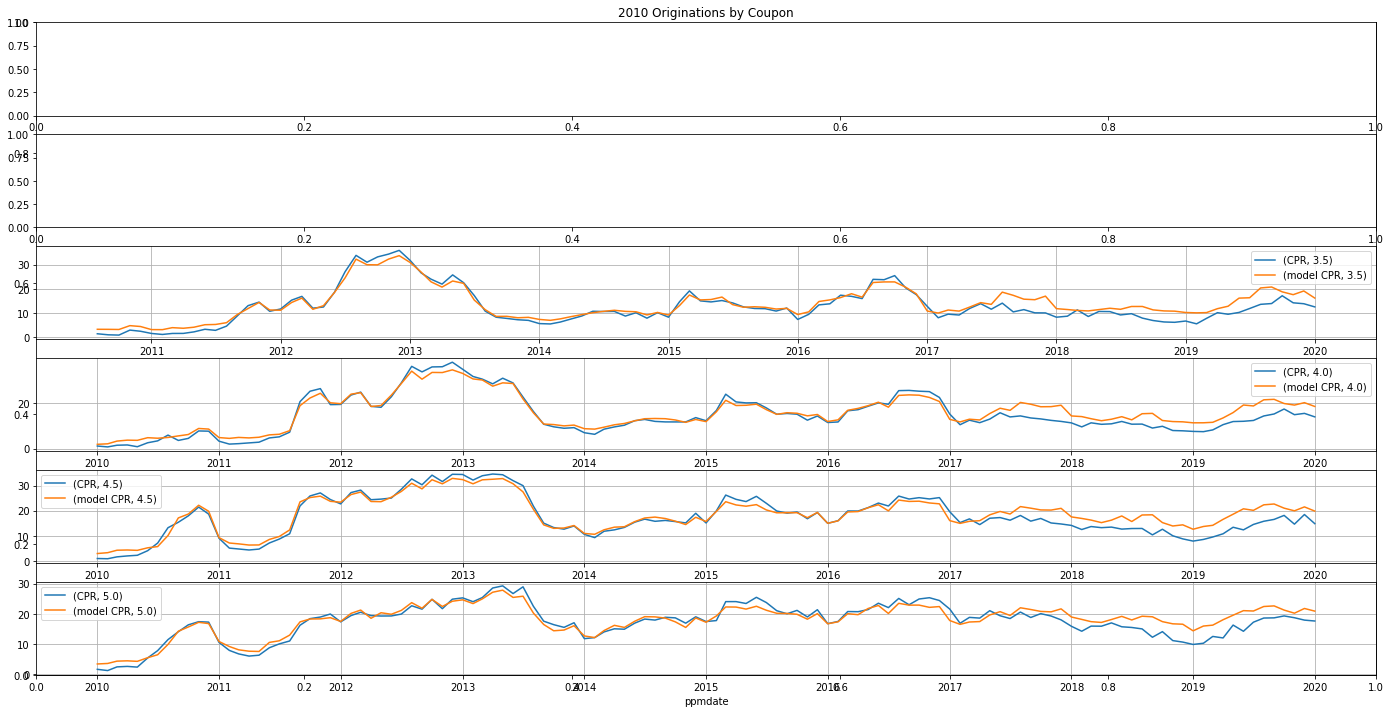

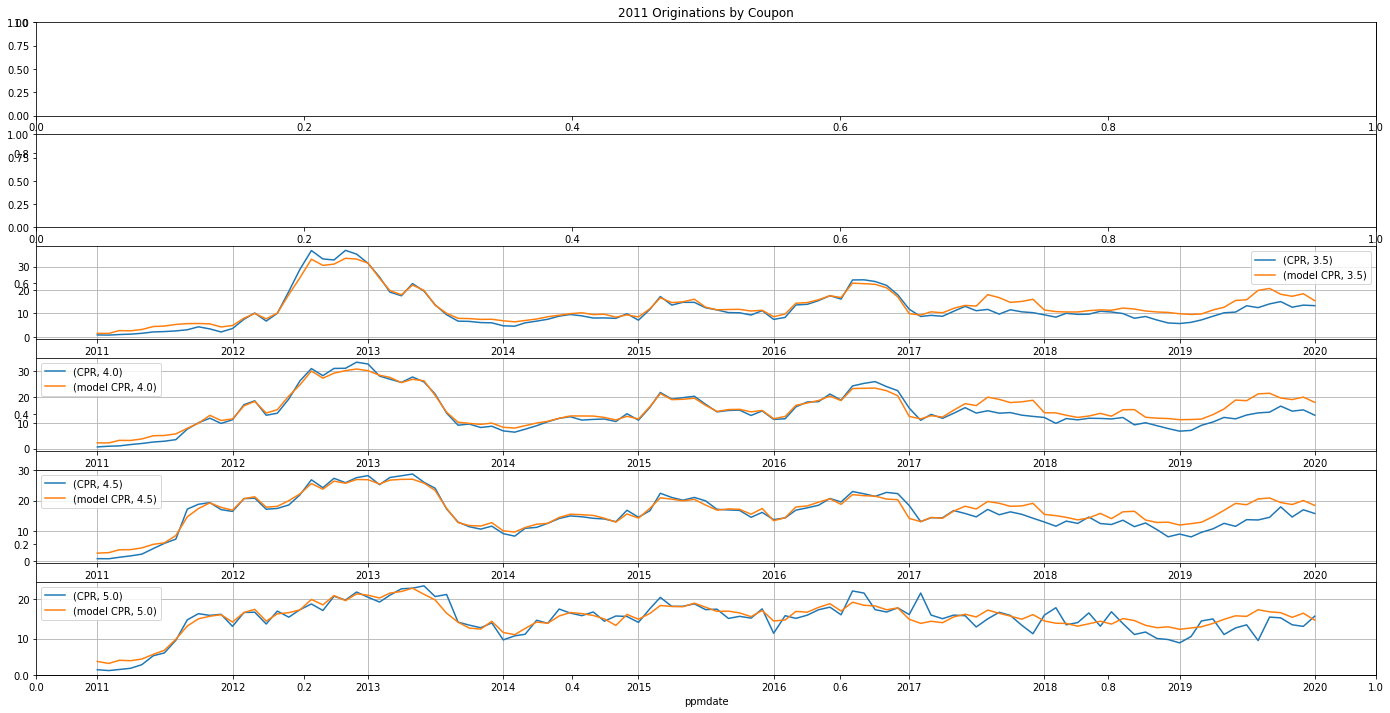

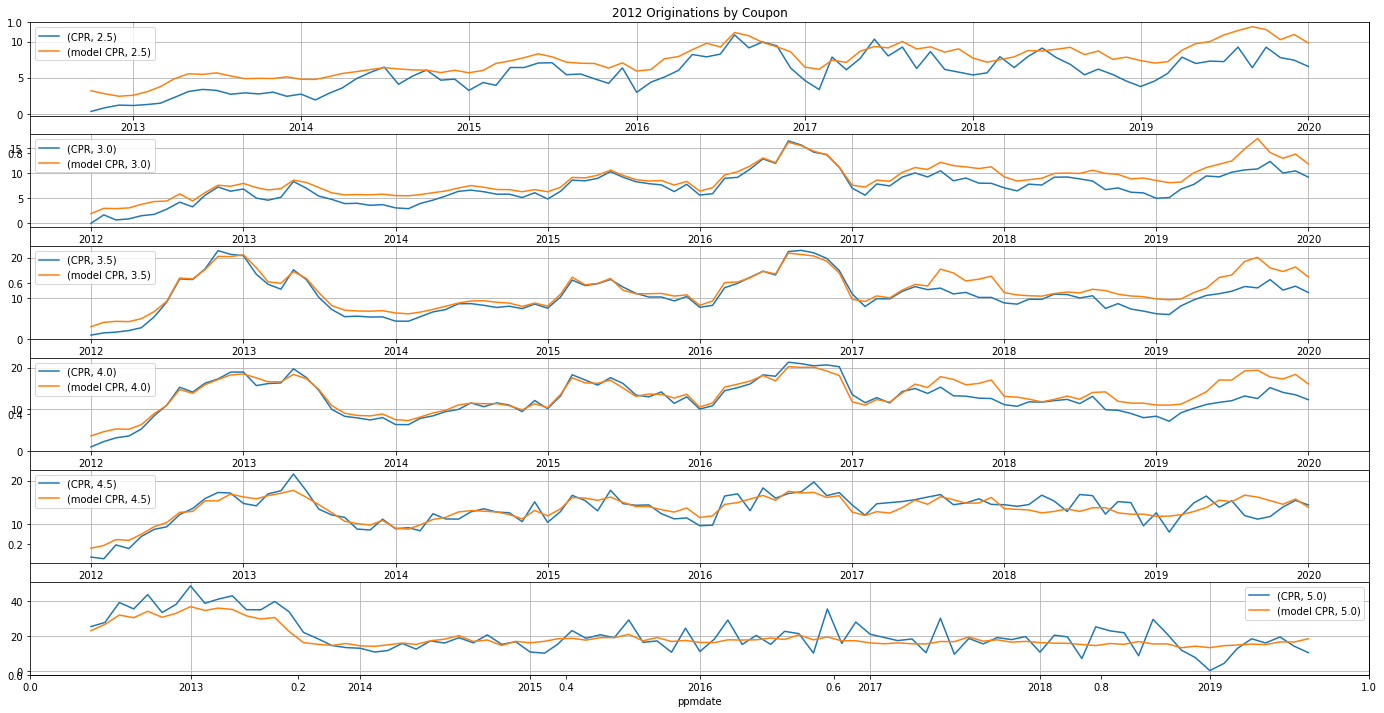

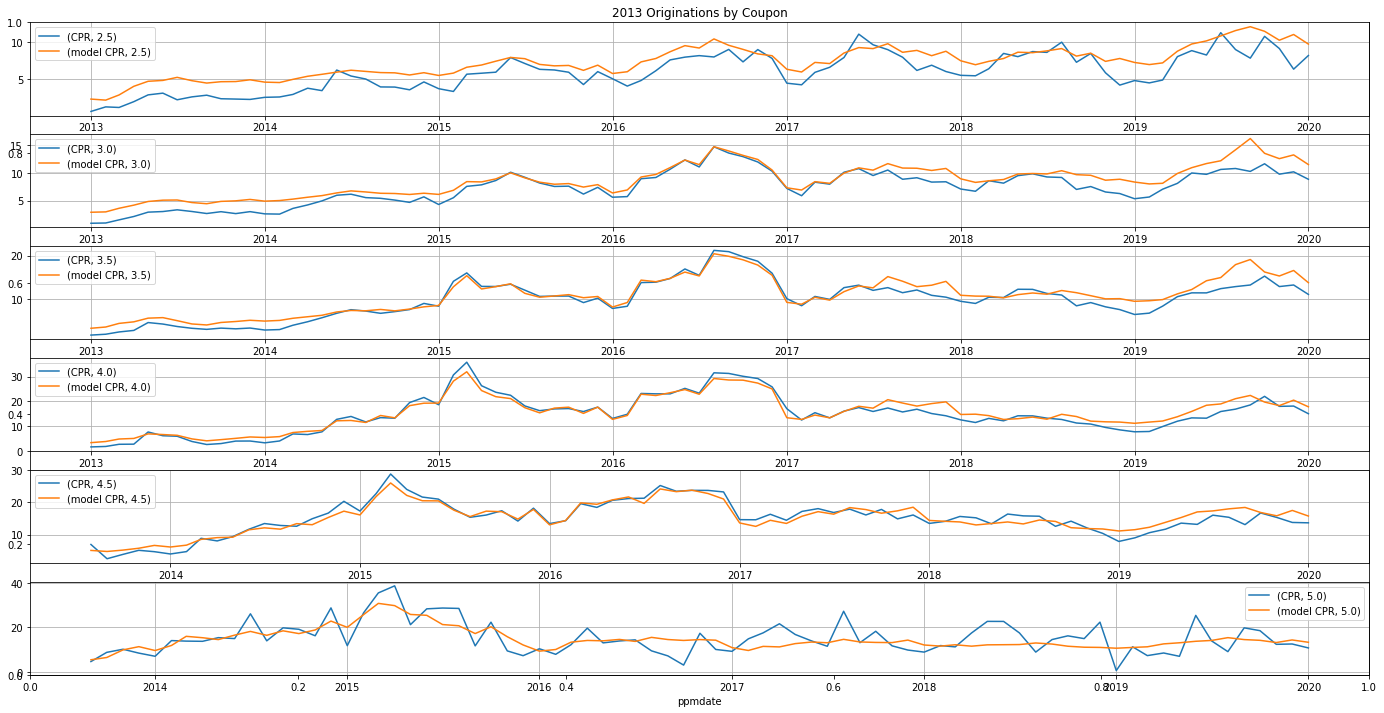

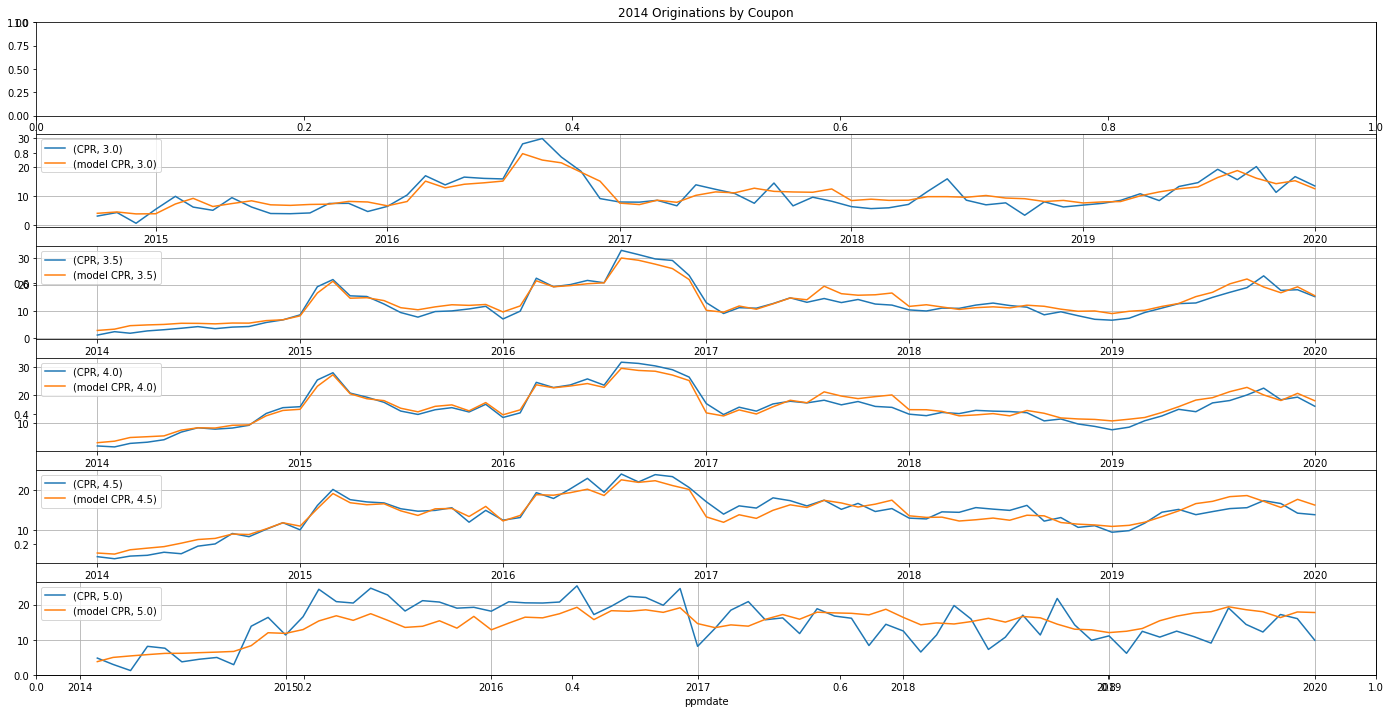

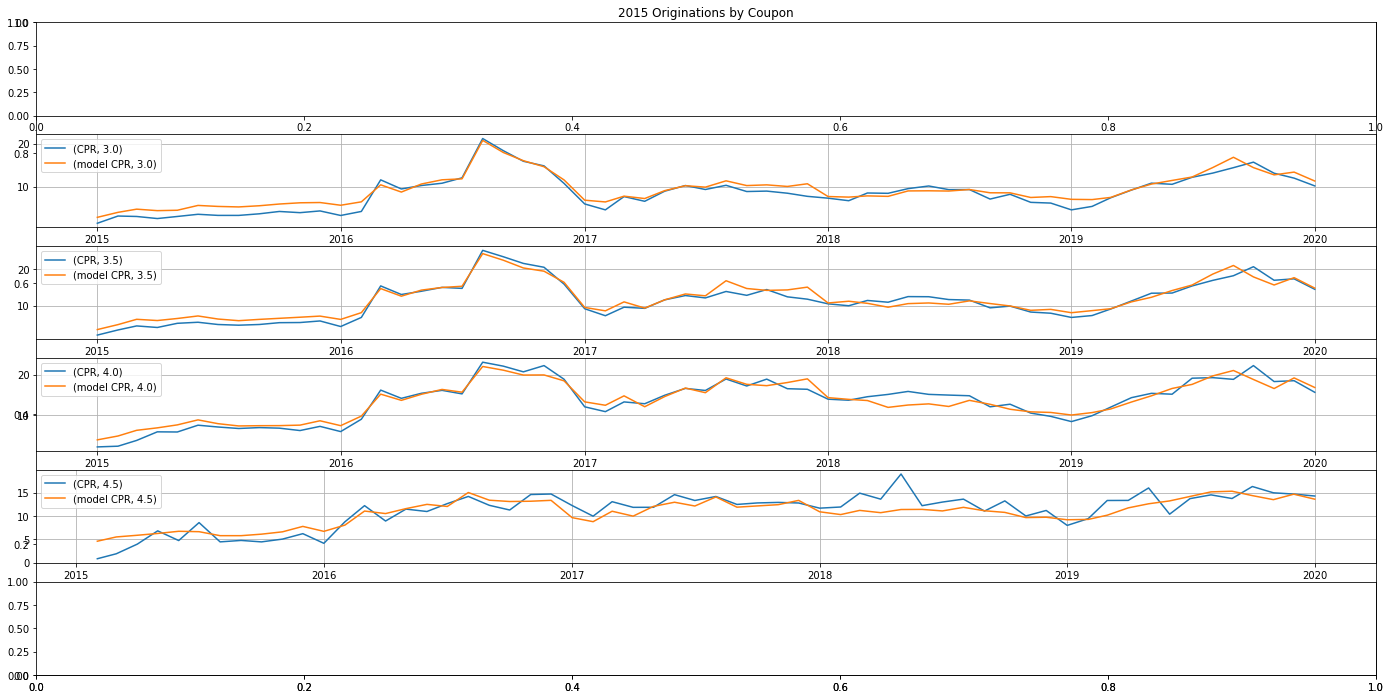

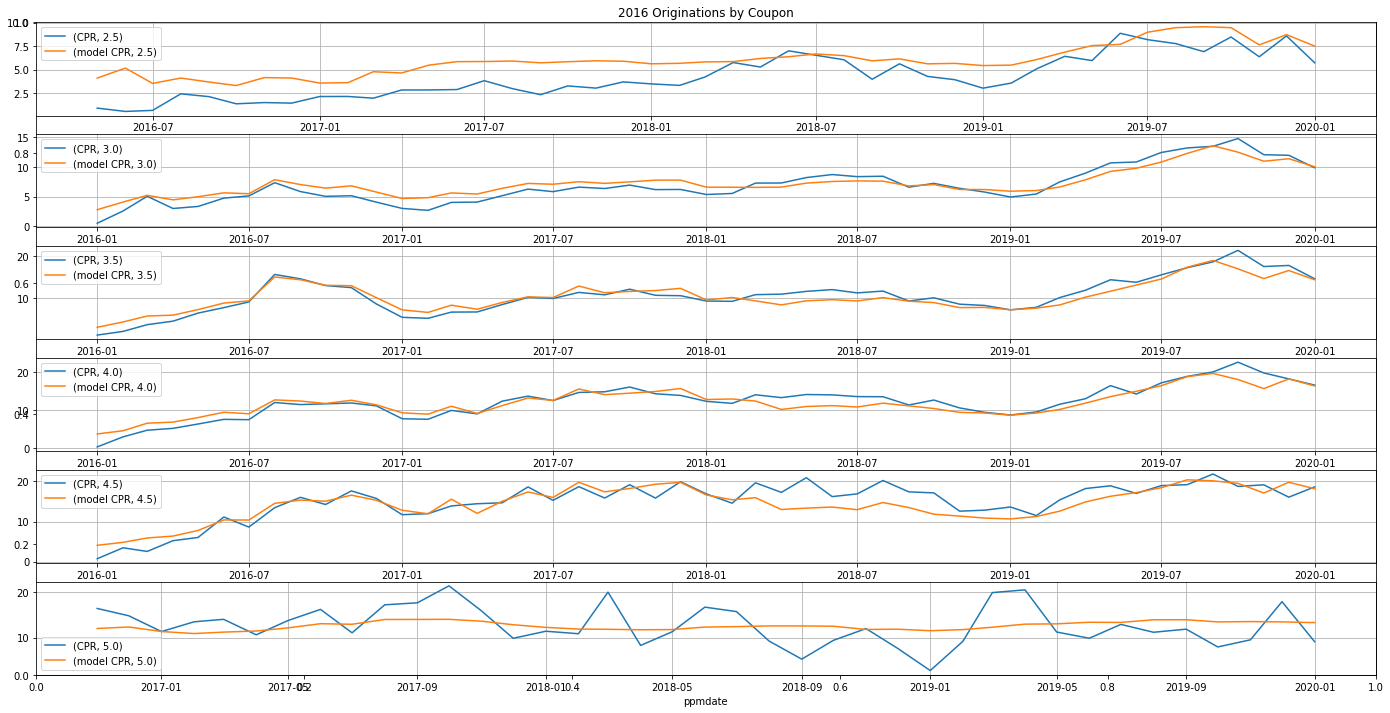

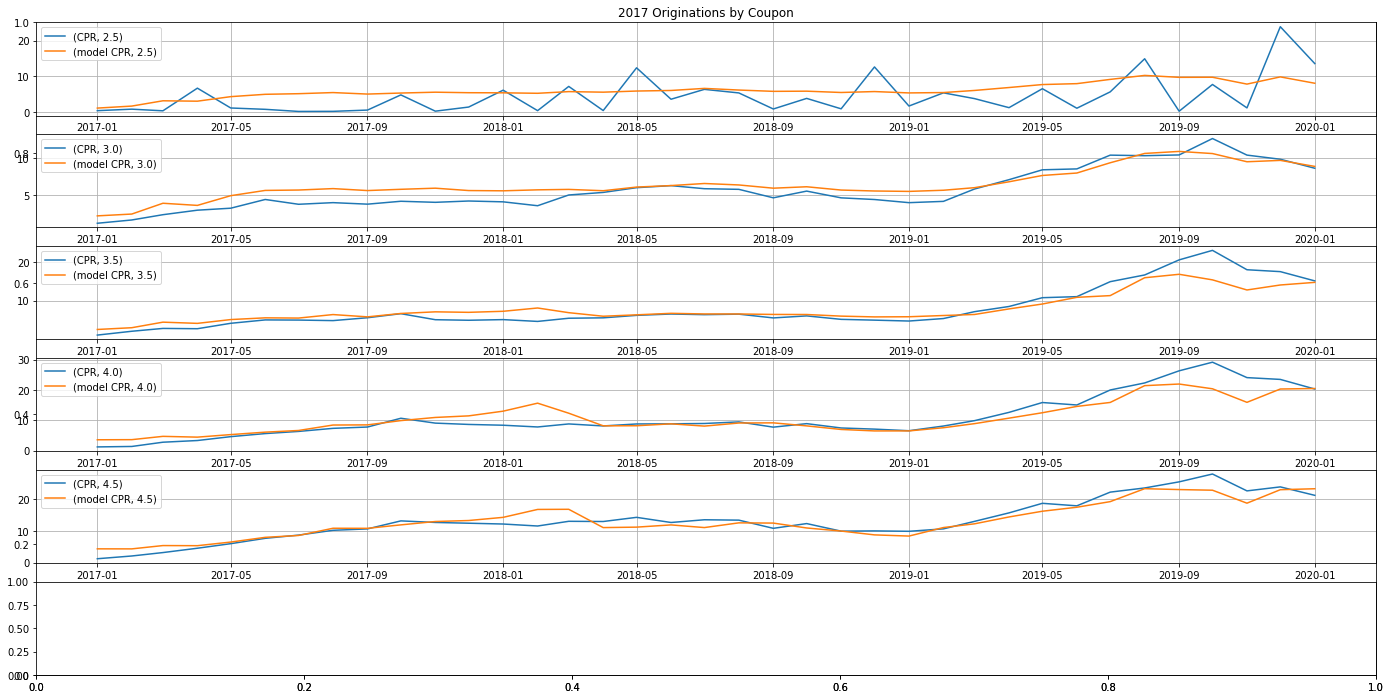

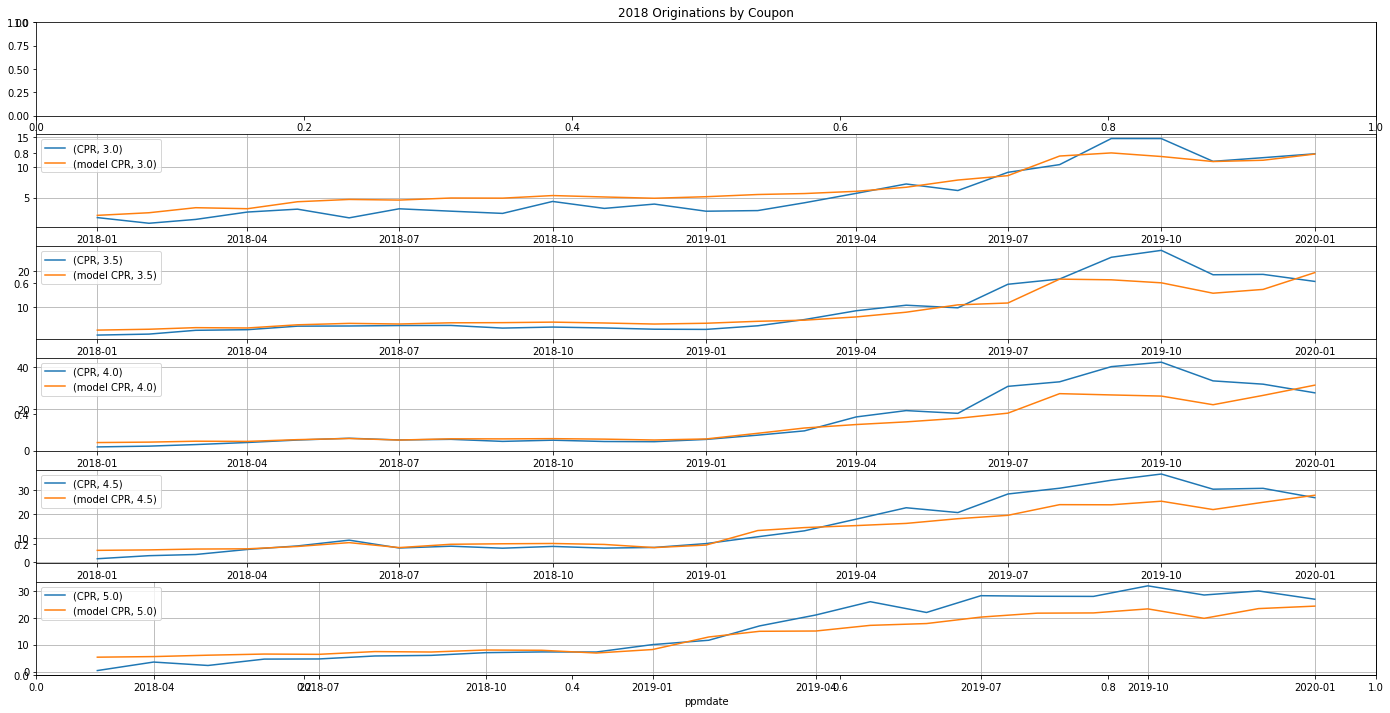

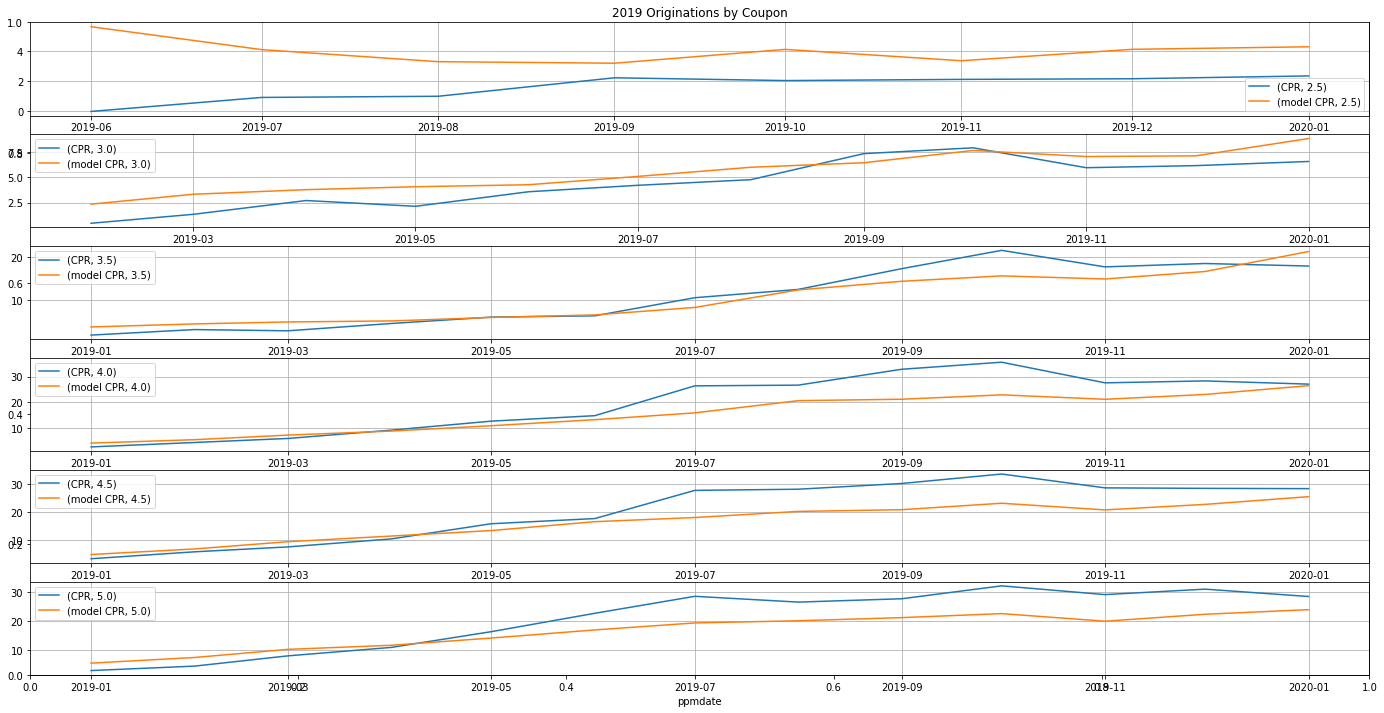

In [58]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:

    valReport(df[df['Vintage'] == vintage],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

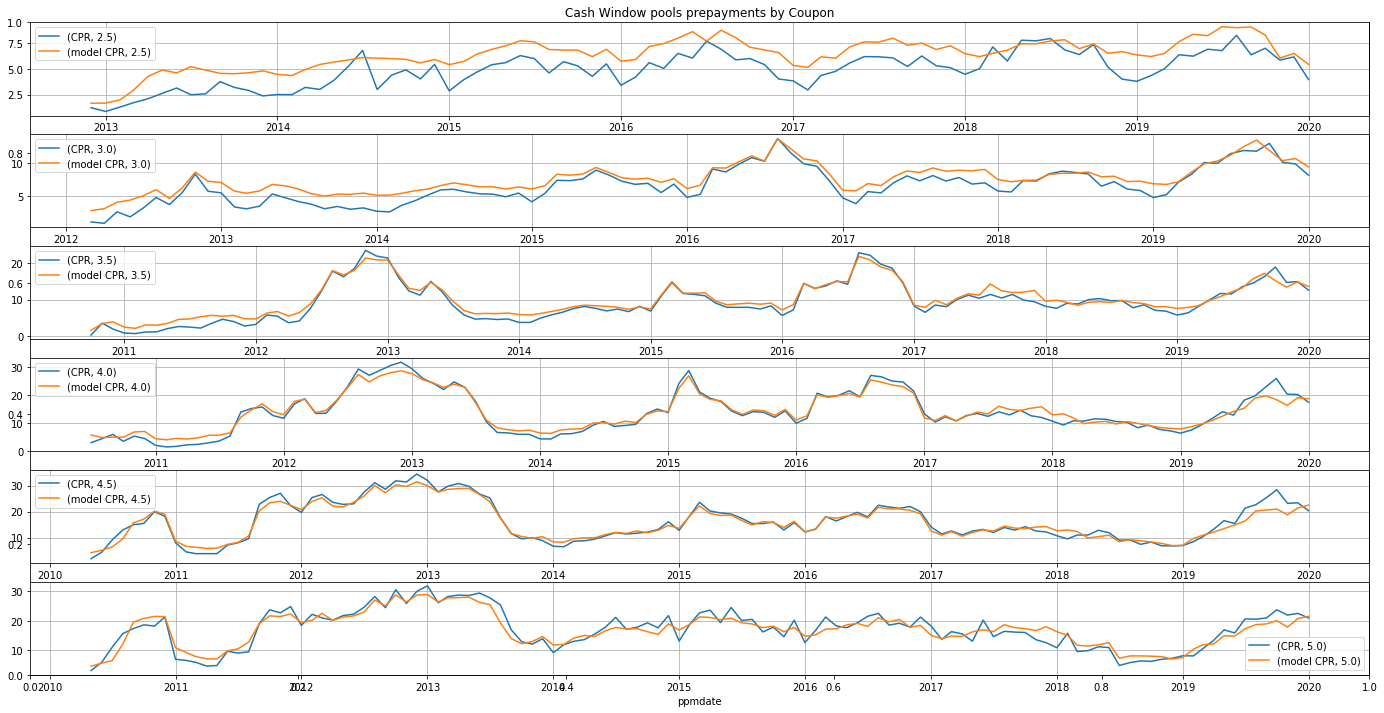

In [59]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

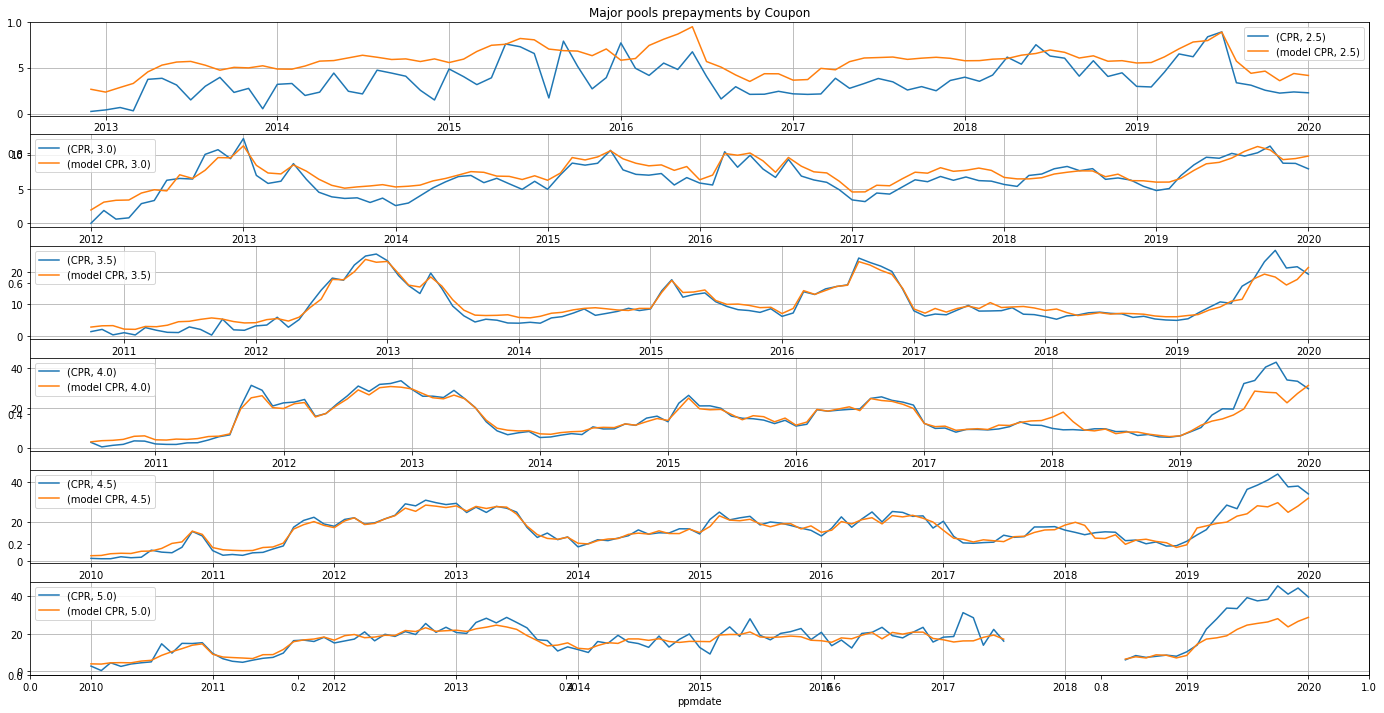

In [60]:
valReport(df[(df['%Majors'] == 100) & (df['Vintage'] > 2009)],graphTitle='Major pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

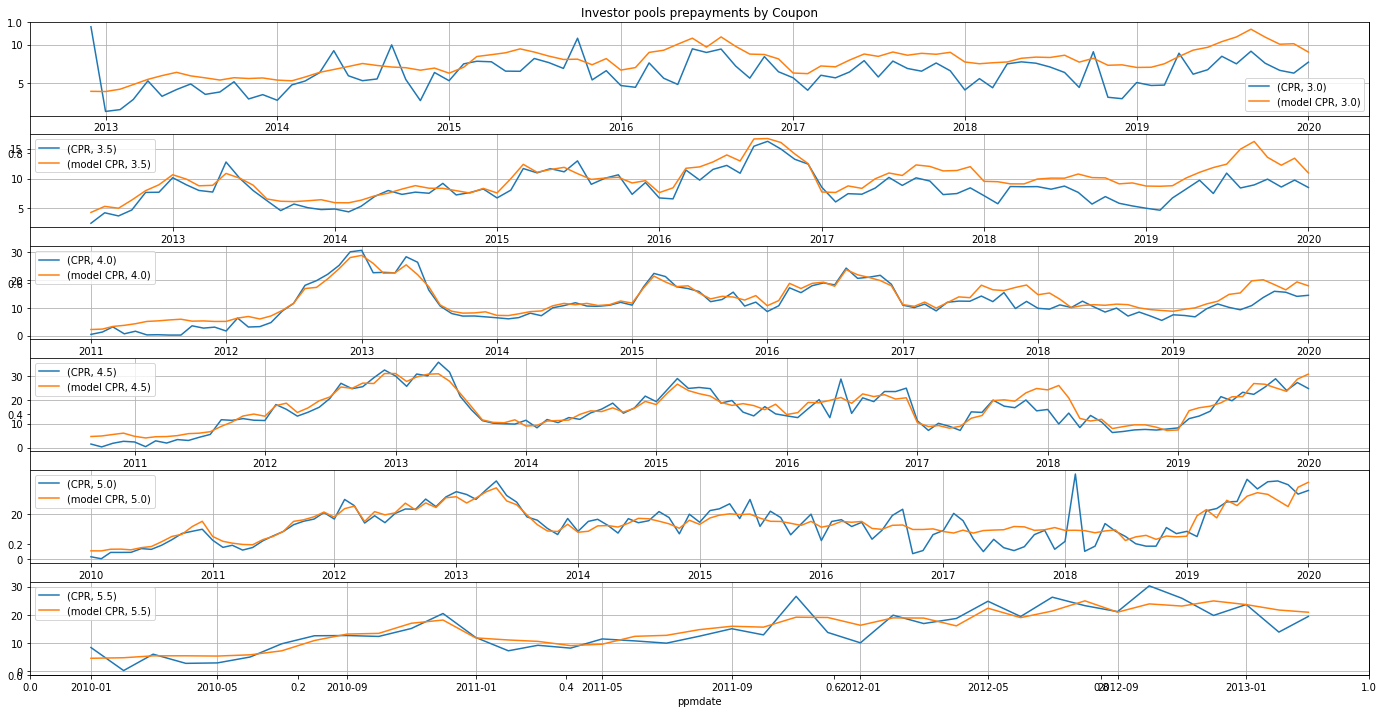

In [61]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

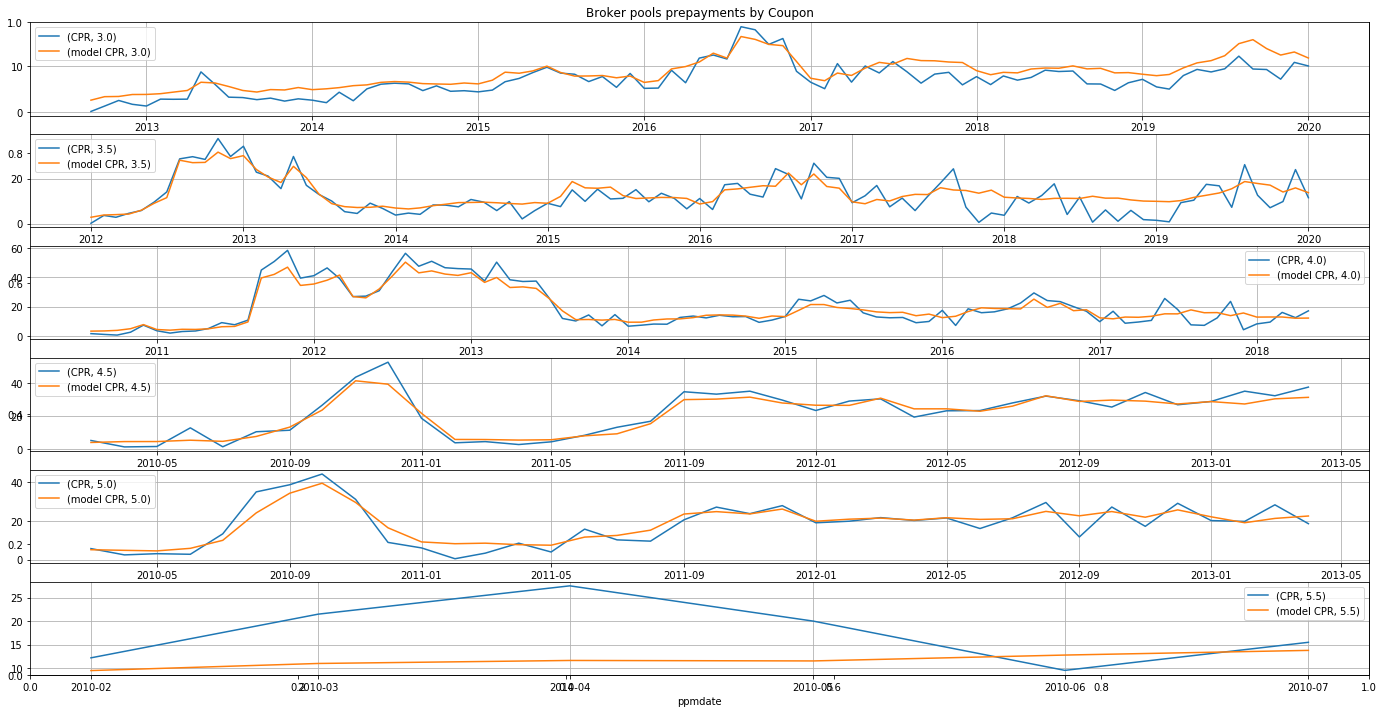

In [62]:
valReport(df[(df['PctChannel_Broker'] > 99) & (df['Vintage'] > 2009)],graphTitle='Broker pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

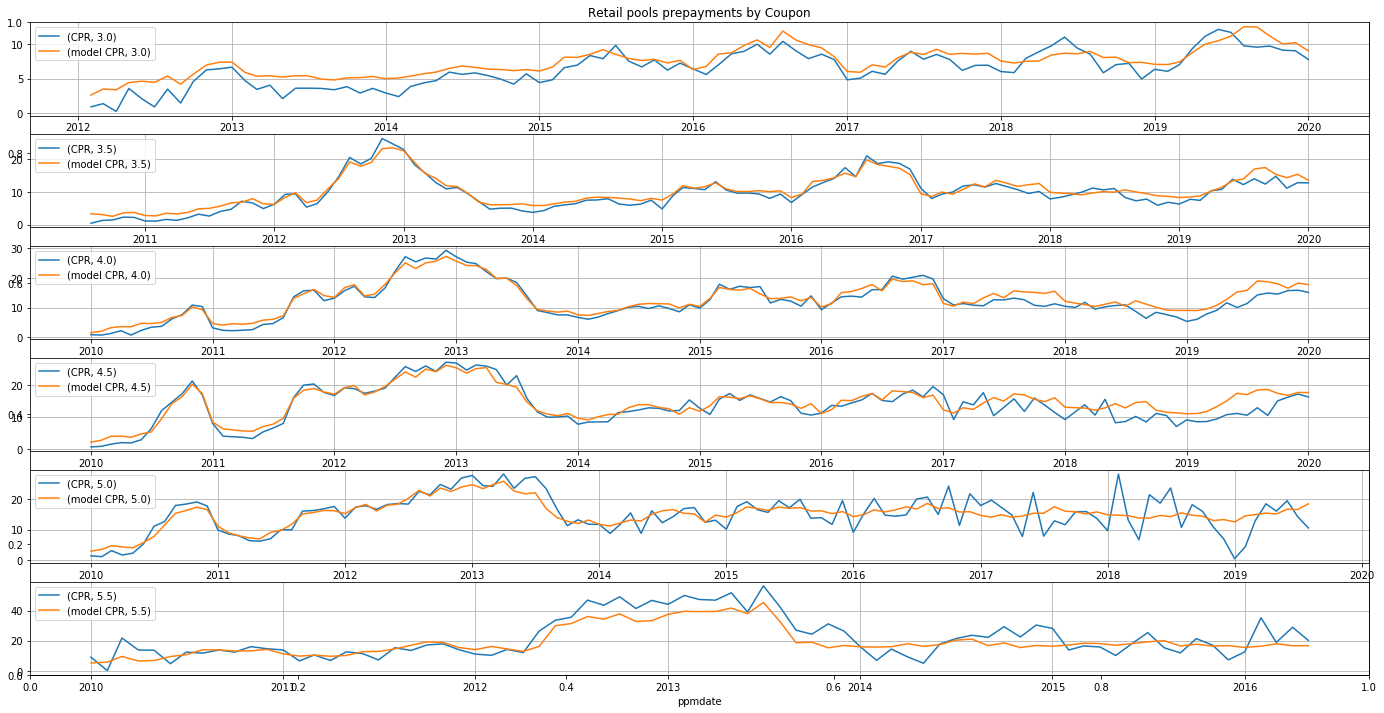

In [63]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

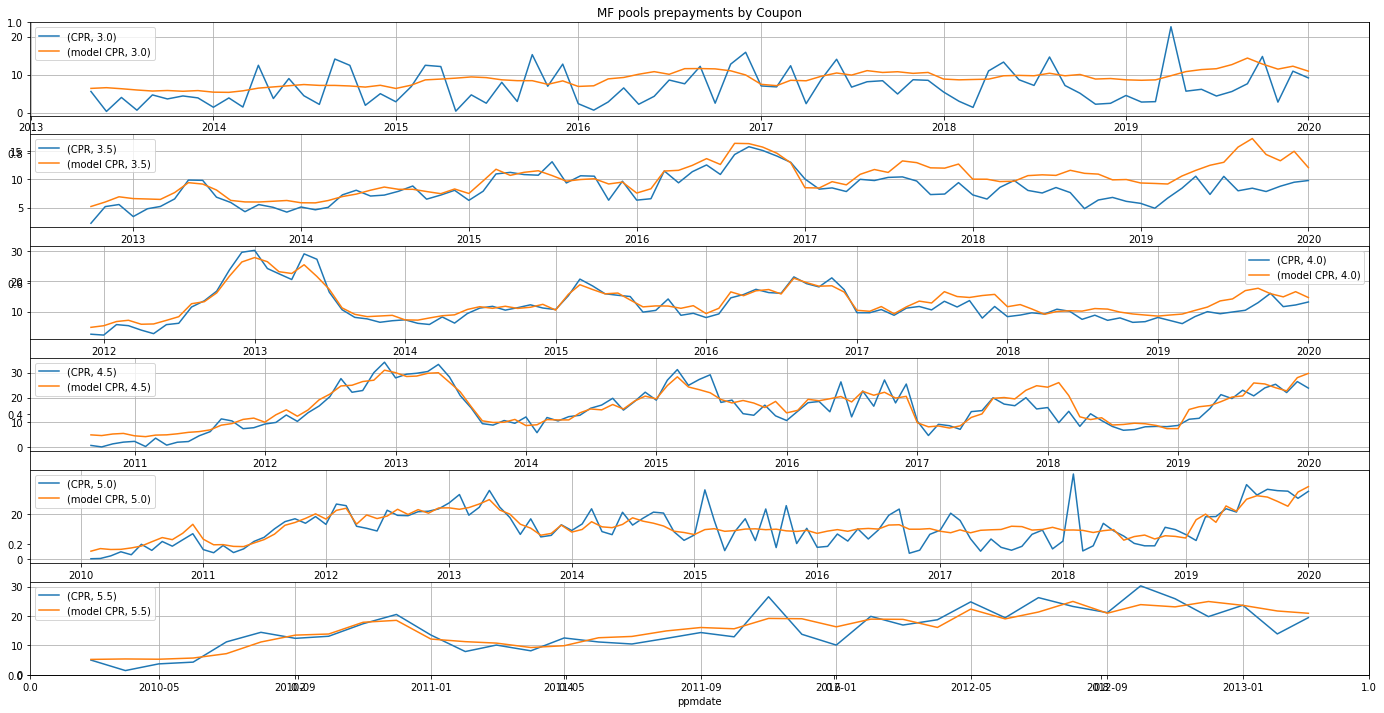

In [64]:
valReport(df[(df['PropUnitsPct_2-4'] > 25) & (df['Vintage'] > 2009)],graphTitle='MF pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

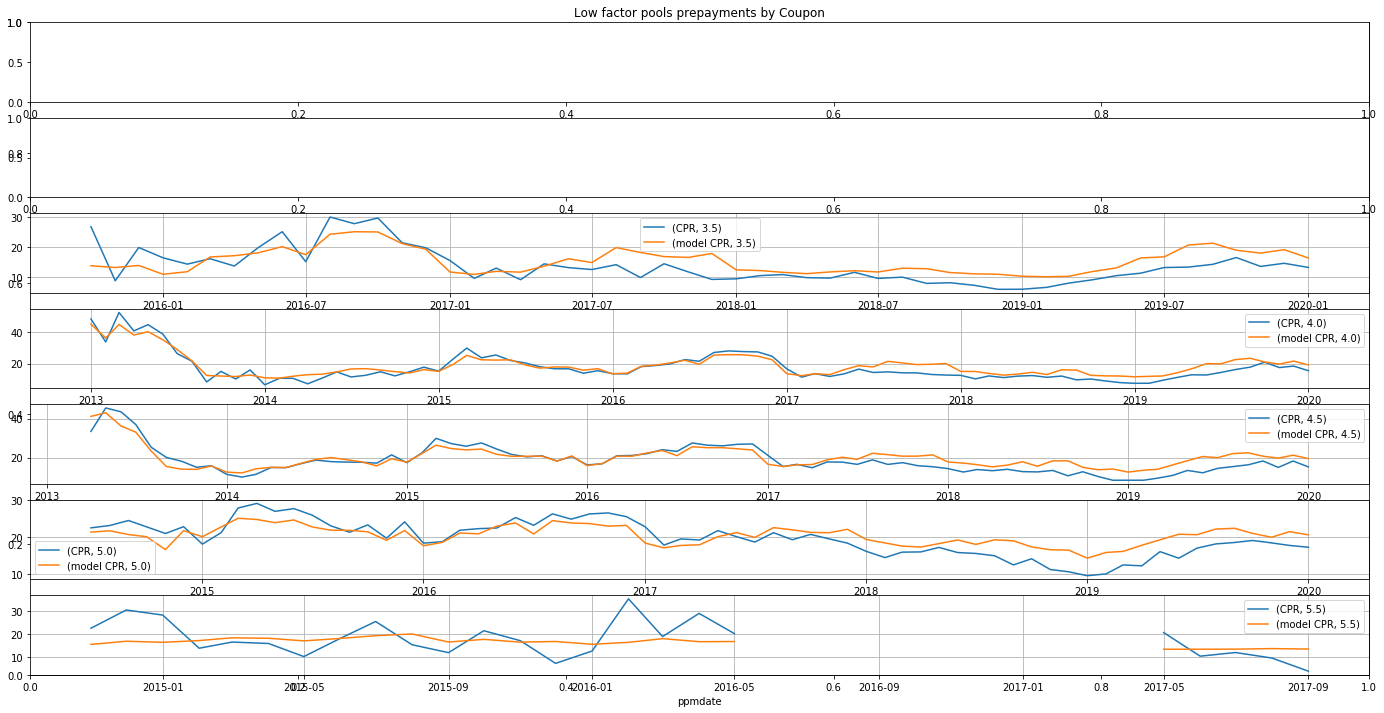

In [65]:
valReport(df[(df['factor'] < 30) & (df['Vintage'] > 2009)],graphTitle='Low factor pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5.5)

### Save the neural network prepayment model in .h5 format

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_name

#### Uncomment the line below if you would like to save

In [ ]:
# model.save(model_name)

#### Uncomment the line below if you would like to load the model saved in Git repository

In [ ]:
# model = load_model('nn-ppm-from-csv.h5')

#### Please, ignore the section below. 

In [ ]:
# import kerastuner as kt 

In [ ]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [ ]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [ ]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [ ]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
# model = tuner.hypermodel.build(best_hps)

In [ ]:
# model.summary()

In [ ]:
# tuner.results_summary()